In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import utils2 

from scipy.sparse.linalg import lsqr


import os
from scipy.sparse import linalg as linalg
from scipy.sparse import lil_matrix as lil_matrix

(119, 110, 3)

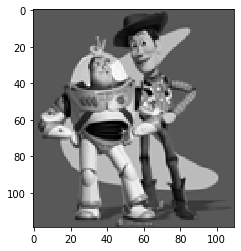

In [2]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB)
plt.imshow(toy_img)
toy_img.shape

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    
    V matrix = toy_img col matrix shape flatten("f")
    A matrix =  2toy_img col matrix shape * toy_img col matrix shape
    """
    rows = toy_img.shape[0]
    cols = toy_img.shape[1]

    source = toy_img.copy()
    c = -1
    counter = 1
    m = toy_img.shape[0]
    n = toy_img.shape[1]
    A = np.zeros((rows*(cols-1) + cols*(rows-1) + 1, toy_img.shape[0]*toy_img.shape[1]), dtype=toy_img.dtype)
    c1 = np.zeros((rows*(cols-1) + cols*(rows-1) + 1, 1), dtype=toy_img.dtype)
    c2 = np.zeros((rows*(cols-1) + cols*(rows-1) + 1, 1), dtype=toy_img.dtype)
    c3 = np.zeros((rows*(cols-1) + cols*(rows-1) + 1, 1), dtype=toy_img.dtype)
    
    for i in range(0, (rows-1)):
        for j in range(cols):
            c+=1
            A[c,(j)*m + i] = -1
            A[c,(j)*m + i + 1] = 1
            c1[c, 0] = toy_img[i + 1,j, 0] - toy_img[i,j, 0]
            c2[c, 0] = toy_img[i + 1,j, 1] - toy_img[i,j, 1]    
            c3[c, 0] = toy_img[i + 1,j, 2] - toy_img[i,j, 2]

            counter +=1
    for i in range(rows):
        for j in range(0, (cols - 1)):
            c +=1
            A[c,(j)*m + i] = -1
            A[c,(j+1)*m + i ] = 1
            c1[c, 0] = toy_img[i ,j+1, 0] - toy_img[i,j, 0]
            c2[c, 0] = toy_img[i ,j+1, 1] - toy_img[i,j, 1]
            c3[c, 0] = toy_img[i ,j+1, 2] - toy_img[i,j, 2]
            
            counter += 1
    
    

    c +=1
    A[c, 0] = 1
    c1[c, 0] = toy_img[0,0, 0]
    c2[c, 0]=toy_img[0,0, 1]
    c3[c, 0]=toy_img[0,0, 2]
    x1 = lsqr(A, c1)[0].reshape(cols, rows).T
    x2 = lsqr(A, c2)[0].reshape(cols, rows).T
    x3 = lsqr(A, c3)[0].reshape(cols, rows).T
    im_out = cv2.merge((x1, x2, x3))
    return im_out
   

In [4]:
im_out = toy_reconstruct(toy_img/255)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(119, 110, 3)

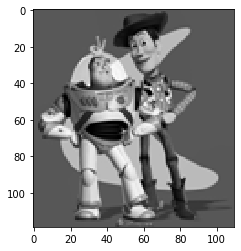

In [5]:
%matplotlib inline
plt.imshow(im_out)
im_out.shape

## Preparation

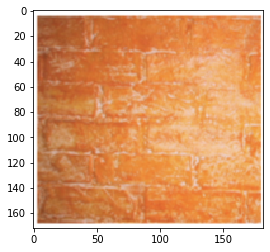

In [508]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/b.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


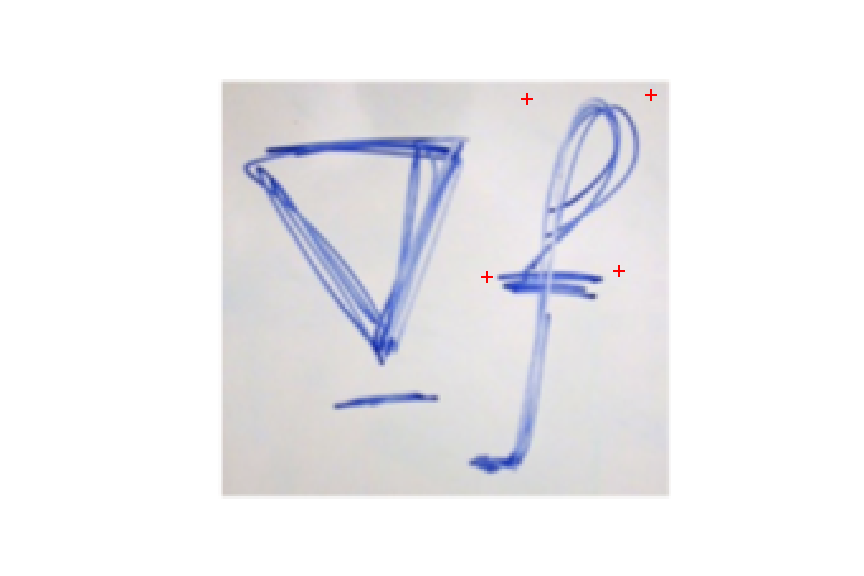

In [513]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/s.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

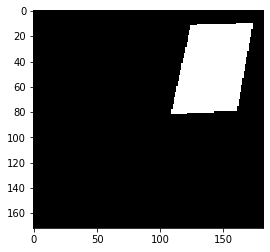

In [514]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


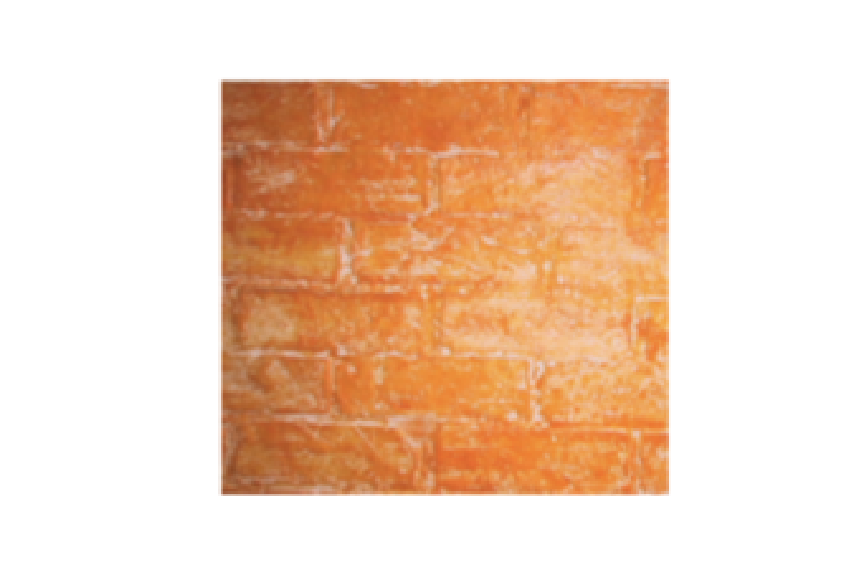

In [515]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

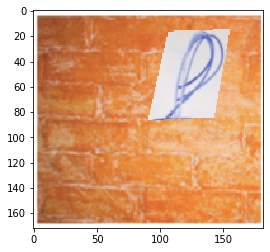

In [516]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

0.0

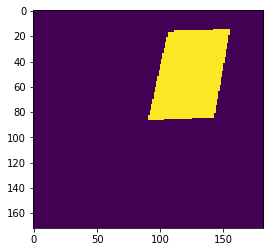

In [517]:
plt.imshow(object_mask)
cropped_object.min()

## Part 2 Poisson Blending (50 pts)

97957

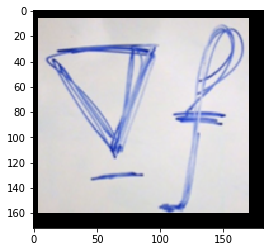

In [300]:
def get_neighbours(i , j):
    return [(i + 1,j),(i - 1, j),(i,j+1),(i, j -1)]
def is_edge(i, j, object_mask):
    if object_mask[i,j] != 1: 
        return False
    for pt in get_neighbours(i,j):
        if object_mask[pt[0],pt[1]] != 1: 
            return True
    return False
plt.imshow(cropped_object)
cropped_object.shape
No

**Poisson blending using lil matrix (which takes longer):**

In [301]:
unknown_value = np.nonzero(object_mask)
No = len(unknown_value[0])
A = lil_matrix((No,No), dtype = np.float64)
b = np.zeros(No, dtype = np.float64)
g = np.zeros(No, dtype = np.float64)
r = np.zeros(No, dtype = np.float64)
target = background_img.copy()
v = list(zip(unknown_value[0], unknown_value[1]))
counter = -1
for i,j in v:
    
    counter +=1
    N = get_neighbours(i,j)
    b[counter] = (4 * cropped_object[i,j,0]) - (1 * cropped_object[i+1, j,0]) - (1 * cropped_object[i-1, j,0])- (1 * cropped_object[i, j+1,0]) - (1 * cropped_object[i, j-1,0])
    g[counter] = (4 * cropped_object[i,j,1]) - (1 * cropped_object[i+1, j,1]) - (1 * cropped_object[i-1, j,1])- (1 * cropped_object[i, j+1,1]) - (1 * cropped_object[i, j-1,1])
    r[counter] = (4 * cropped_object[i,j,2]) - (1 * cropped_object[i+1, j, 2]) - (1 * cropped_object[i-1, j,2])- (1 * cropped_object[i, j+1,2]) - (1 * cropped_object[i, j-1,2])


    A[counter , counter] = 4
    for tu in N:
        if tu in v: 
            h = v.index(tu)
#             print(tu,counter,h)
            A[counter,h] = -1
        if  (object_mask[tu[0],tu[1]] != 1) & (is_edge(i,j, object_mask) == True): 
            b[counter] += target[tu[0], tu[1], 0]
            g[counter] += target[tu[0], tu[1], 1]
            r[counter] += target[tu[0], tu[1], 2]
#             print("b" , b[counter])
x = linalg.cg(A, b)
y = linalg.cg(A, g)
z = linalg.cg(A, r)


composite1 = np.copy(target[:,:,0]).astype(np.float64)
composite2 = np.copy(target[:,:,1]).astype(np.float64)
composite3 = np.copy(target[:,:,2]).astype(np.float64)
print(composite1.shape)
for i,index in enumerate(v):
    composite1[index[0], index[1] ] = x[0][i]
    composite2[index[0], index[1] ] = y[0][i]
    composite3[index[0], index[1] ] = z[0][i]


result = cv2.merge([composite1,composite2,composite3])

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.550234457719316

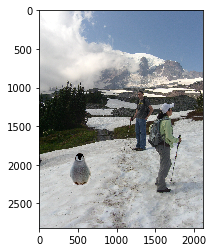

In [355]:
plt.imshow(result)
result.max()



**Poisson blending using lil, converted to csr and lsqr solver: (which is faster):**

In [302]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    unknown_value = np.nonzero(object_mask)
    No = len(unknown_value[0])
    A = lil_matrix((No,No), dtype = np.float64)
    b = np.zeros(No, dtype = np.float64)
    g = np.zeros(No, dtype = np.float64)
    r = np.zeros(No, dtype = np.float64)
    target = background_img.copy()
    v = list(zip(unknown_value[0], unknown_value[1]))
    print(len(v))
    counter = -1
    for i,j in v:
        if counter%50 == 0: print(counter)
        counter +=1
        N = get_neighbours(i,j)
        b[counter] = (4 * cropped_object[i,j,0]) - (1 * cropped_object[i+1, j,0]) - (1 * cropped_object[i-1, j,0])- (1 * cropped_object[i, j+1,0]) - (1 * cropped_object[i, j-1,0])
        g[counter] = (4 * cropped_object[i,j,1]) - (1 * cropped_object[i+1, j,1]) - (1 * cropped_object[i-1, j,1])- (1 * cropped_object[i, j+1,1]) - (1 * cropped_object[i, j-1,1])
        r[counter] = (4 * cropped_object[i,j,2]) - (1 * cropped_object[i+1, j, 2]) - (1 * cropped_object[i-1, j,2])- (1 * cropped_object[i, j+1,2]) - (1 * cropped_object[i, j-1,2])


        A[counter , counter] = 4
        for tu in N:
            if tu in v: 
                h = v.index(tu)
    #             print(tu,counter,h)
                A[counter,h] = -1
            if  (object_mask[tu[0],tu[1]] != 1) & (is_edge(i,j, object_mask) == True): 
                b[counter] += target[tu[0], tu[1], 0]
                g[counter] += target[tu[0], tu[1], 1]
                r[counter] += target[tu[0], tu[1], 2]
    #             print("b" , b[counter])
    
    A_prime = A.tocsr(copy = True)
    x = lsqr(A_prime, b)
    y = lsqr(A_prime, g)
    z = lsqr(A_prime, r)


    composite1 = np.copy(target[:,:,0]).astype(np.float64)
    composite2 = np.copy(target[:,:,1]).astype(np.float64)
    composite3 = np.copy(target[:,:,2]).astype(np.float64)
    print(composite1.shape)
    for i,index in enumerate(v):
        composite1[index[0], index[1] ] = x[0][i]
        composite2[index[0], index[1] ] = y[0][i]
        composite3[index[0], index[1] ] = z[0][i]


    result = cv2.merge([composite1,composite2,composite3])
    return result

16914
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(172, 182)


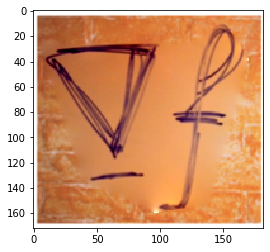

In [303]:
im_blend = poisson_blend(cropped_object, object_mask, background_img)

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(im_blend)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


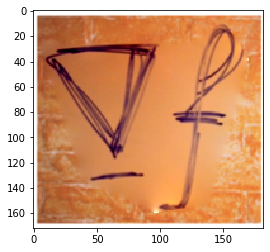

In [304]:
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [366]:
def get_proper_gradient(cropped_object, target, i, j, c):
        if abs((cropped_object[i,j,c]) - (cropped_object[i+1, j,c])) >=  abs((target[i,j,c]) - (target[i+1, j,c])) :
            b1 = (cropped_object[i,j,c]) - (cropped_object[i+1, j,c])
        else:
            b1 = (target[i,j,c]) - (target[i+1, j,c])
        
        if abs((cropped_object[i,j,c]) - (cropped_object[i-1, j,c])) >=  abs((target[i,j,c]) - (target[i-1, j,c])) :
            b2 = (cropped_object[i,j,c]) - (cropped_object[i-1, j,c])
        else:
            b2 = (target[i,j,c]) - (target[i-1, j,c])
        
        if abs((cropped_object[i,j,c]) - (cropped_object[i, j+1,c])) >=  abs((target[i,j,c]) - (target[i, j+1,c])) :
            b3 = (cropped_object[i,j,c]) - (cropped_object[i, j+1,c])
        else:
            b3 = (target[i,j,c]) - (target[i, j+1,c])
            
        if abs((cropped_object[i,j,c]) - (cropped_object[i, j-1,c])) >=  abs((target[i,j,c]) - (target[i, j-1,c])) :
            b4 = (cropped_object[i,j,c]) - (cropped_object[i, j-1,c])
        else:
            b4 = (target[i,j,c]) - (target[i, j-1,c])
        return (b1+b2+b3+b4)
def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    unknown_value = np.nonzero(object_mask)
    No = len(unknown_value[0])
    A = lil_matrix((No,No), dtype = np.float64)
    b = np.zeros(No, dtype = np.float64)
    g = np.zeros(No, dtype = np.float64)
    r = np.zeros(No, dtype = np.float64)
    target = background_img.copy()
    v = list(zip(unknown_value[0], unknown_value[1]))
    counter = -1
    for i,j in v:

        counter +=1
        N = get_neighbours(i,j)

        b[counter] = get_proper_gradient(cropped_object, target, i, j, 0)
        g[counter] =  get_proper_gradient(cropped_object, target, i, j, 1)
        r[counter] =  get_proper_gradient(cropped_object, target, i, j, 2)


        A[counter , counter] = 4
        for tu in N:
            if tu in v: 
                h = v.index(tu)
    #             print(tu,counter,h)
                A[counter,h] = -1
            if  (object_mask[tu[0],tu[1]] != 1) & (is_edge(i,j, object_mask) == True): 
                b[counter] += target[tu[0], tu[1], 0]
                g[counter] += target[tu[0], tu[1], 1]
                r[counter] += target[tu[0], tu[1], 2]
    #             print("b" , b[counter])
    x = linalg.cg(A, b)
    y = linalg.cg(A, g)
    z = linalg.cg(A, r)


    composite1 = np.copy(target[:,:,0]).astype(np.float64)
    composite2 = np.copy(target[:,:,1]).astype(np.float64)
    composite3 = np.copy(target[:,:,2]).astype(np.float64)
    print(composite1.shape)
    for i,index in enumerate(v):
        composite1[index[0], index[1] ] = x[0][i]
        composite2[index[0], index[1] ] = y[0][i]
        composite3[index[0], index[1] ] = z[0][i]


    result = cv2.merge([composite1,composite2,composite3])
        #TO DO 
    return result

In [367]:
im_mix = mix_blend(cropped_object, object_mask, background_img)
# if im_mix and im_mix.any():
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(im_mix)

IndexError: too many indices for array

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [31]:
def get_proper_intensity(source, i1, j1, i2, j2, c):

    l = {}
    if (abs((source[i1,j1,0]) - (source[i2, j2,0]))==0):
        l[abs((source[i1,j1,0]) - (source[i2, j2,0]))] = 1
    else:
        l[abs((source[i1,j1,0]) - (source[i2, j2,0]))] = ((source[i1,j1,0]) - (source[i2, j2,0])) / abs((source[i1,j1,0]) - (source[i2, j2,0]))
        
    if abs((source[i1,j1,1]) - (source[i2, j2,1])) == 0:
        
        l[abs((source[i1,j1,1]) - (source[i2, j2,1]))] = 1
    else:
        l[abs((source[i1,j1,1]) - (source[i2, j2,1]))] = ((source[i1,j1,1]) - (source[i2, j2,1])) / abs((source[i1,j1,1]) - (source[i2, j2,1]))
    
    if  abs((source[i1,j1,2]) - (source[i2, j2,2])) == 0:
        l[abs((source[i1,j1,2]) - (source[i2, j2,2]))] = 1
    else:
        l[abs((source[i1,j1,2]) - (source[i2, j2,2]))] = ((source[i1,j1,2]) - (source[i2, j2,2])) / abs((source[i1,j1,2]) - (source[i2, j2,2]))
    
    maxval =  max(l.keys())
        
    
    return  maxval
def color_to_gray(source):
    
    rows = source.shape[0]
    cols = source.shape[1]
    m = source.shape[0]
    n = source.shape[1]
    c = -1
    counter = 1
    
    A = np.zeros((rows*(cols-1) + cols*(rows-1) + 1, rows*cols), dtype=source.dtype)
    c1 = np.zeros((rows*(cols-1) + cols*(rows-1) + 1, 1), dtype=source.dtype)
    
    
    for i in range(0, (rows-1)):
        for j in range(cols):
            if c%10000 == 0:
                print(c)
            c+=1
            A[c,(j)*m + i] = -1
            A[c,(j)*m + i + 1] = 1
            c1[c, 0] = get_proper_intensity(source, i+1, j, i,j,  0)

    for i in range(rows):
        for j in range(0, (cols - 1)):
            if c%10000 == 0:
                print(c)
            c +=1
            A[c,(j)*m + i] = -1
            A[c,(j+1)*m + i ] = 1
            c1[c, 0] = get_proper_intensity(source, i, j+1, i,j,  0)            
    
    

    c +=1
    A[c, 0] = 1
    print("compl")
    c1[c, 0] = (source[0,0,0] + source[0,0,1] + source[0,0,2]) / 3
    
    x1 = lsqr(A, c1)[0].reshape(cols, rows).T

    return x1
   

In [32]:
colored_path = "./samples/colorBlind4.png"
colored = cv2.cvtColor(cv2.imread(colored_path), cv2.COLOR_BGR2RGB)

colored = colored /255

im_out = color_to_gray(colored)
plt.imshow(im_out, cmap="gray")

0
10000
20000
30000
40000
50000
60000
compl


KeyboardInterrupt: 

In [17]:
def color2gray(img):
    

## Laplacian pyramid blending (20 pts)

In [36]:
import cv2
import numpy as np,sys
import sys
import os
import numpy as np
import cv2
import scipy
from scipy.stats import norm
from scipy.signal import convolve2d
import math

cutoff_low = 2
def Gaussian_Pyramid_Down(im2_input):
    gaussian_kernel = utils2.gaussian_kernel(cutoff_low,3*cutoff_low )
    if len(im2_input.shape) == 2:
        im2_gaussian_filtered = convolve2d(im2_input, gaussian_kernel, mode='same',boundary='symm')
    else:
        im2_gaussian_filtered = cv2.filter2D(im2_input, ddepth=-1, kernel = gaussian_kernel)


    return im2_gaussian_filtered, im2_gaussian_filtered[::2, ::2]

def Laplacian_Pyramid(A):
    G = A.copy()
    gpA = [G]
    smoothed = []
    original = [G]
    for i in range(4):
        smooth, downsampled = Gaussian_Pyramid_Down(G)
        smoothed.append(smooth)
        original.append(downsampled)
        G = downsampled
    lpA = []
    for i in range(0, len(smoothed)):
        lpA.append(original[i] - smoothed[i])
    return lpA

def Pyramid_collapse(lapl_pyr):
    output = None
    output = np.zeros((lapl_pyr[0].shape[0],lapl_pyr[0].shape[1]), dtype=np.float64)
    for i in range(len(lapl_pyr)-1,0,-1):
        lap = iexpand(lapl_pyr[i])
        lapb = lapl_pyr[i-1]
        if lap.shape[0] > lapb.shape[0]:
            lap = np.delete(lap,(-1),axis=0)
        if lap.shape[1] > lapb.shape[1]:
            lap = np.delete(lap,(-1),axis=1)
        tmp = lap + lapb
        lapl_pyr = lapl_pyr[:-2]
        lapl_pyr.append(tmp)
        output = tmp
    return output
def iexpand(image):
    out = None
    kernel = generating_kernel(0.4)
    outimage = np.zeros((image.shape[0]*2, image.shape[1]*2, 3), dtype=np.float64)
    outimage[::2,::2, 0]=image[:,:,0]
    outimage[::2,::2, 1]=image[:,:,1]
    outimage[::2,::2, 2]=image[:,:,2]


#     out = 4*scipy.signal.convolve2d(outimage,kernel,'same')
    out = 4*cv2.filter2D(outimage, ddepth=-1, kernel = kernel)


    return out


def generating_kernel(a):
    w_1d = np.array([0.25 - a/2.0, 0.25, a, 0.25, 0.25 - a/2.0])
    return np.outer(w_1d, w_1d)

def laplacian_blend(img1, img2, mask):
    print(img1.min(), img1.max(), img2.min(), img2.max())
    im1_lp = Laplacian_Pyramid(img1)
    fig, axes = plt.subplots(2, 4)
    for i in range(0,4):
#         axes[0][i].imshow(original[i], cmap= 'gray')
        axes[0][i].imshow(im1_lp[i],cmap='gray')
    
    im2_lp = Laplacian_Pyramid(img2) 
    for i in range(0,4):
#         axes[0][i].imshow(original[i], cmap= 'gray')
        axes[1][i].imshow(im1_lp[i],cmap='gray')
    
    mask_g = [mask]
    for i in range(4):
#         print(mask.shape)
        smooth, downsampled = Gaussian_Pyramid_Down(mask)
        mask_g.append(downsampled)
        mask = downsampled
    
    combined_pyramid = []
    counter = 0
    for l in range(0,4):
        x = mask_g[l]*im1_lp[l][:,:,0] + (1-mask_g[l])*im2_lp[l][:,:,0]
        y = mask_g[l]*im1_lp[l][:,:,1] + (1-mask_g[l])*im2_lp[l][:,:,1]
        z = mask_g[l]*im1_lp[l][:,:,2] + (1-mask_g[l])*im2_lp[l][:,:,2]
        im = cv2.merge((x,y,z))

        combined_pyramid.append(im)
    
    result = Pyramid_collapse(combined_pyramid)
    return result
        

In [37]:
# cropped_object = cv2.cvtColor(cropped_object,cv2.COLOR_BGR2GRAY)/255
# background_img = cv2.cvtColor(background_img,cv2.COLOR_BGR2GRAY)/255


out = laplacian_blend(cropped_object, background_img,object_mask)
plt.imshow(out)

NameError: name 'cropped_object' is not defined

## More gradient domain processing (up to 20 pts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


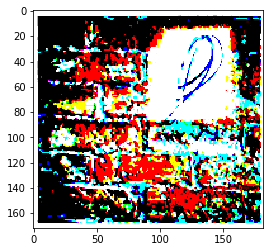

In [580]:
plt.imshow(out)